# Modèles pré-entrainé pour la vision par ordinateur

Le but de ce notebook est d'acquérir une expérience pratique avec des modèles Keras pré-entraînés qui sont raisonnablement proches de l'état de l'art de certaines tâches de vision par ordinateur. 

Les modèles sont pré-entraînés sur de grands ensembles de données d'images étiquetées accessibles au public tels que [ImageNet] (http://www.image-net.org/) et [COCO] (http://cocodataset.org/).

Ce notebook met en évidence deux tâches spécifiques:

- **Classification d'image**: prédire une seule étiquette de classe par image (en supposant un seul objet centré ou une seule classe d'image)

- **Détection d'objets et segmentation d'instances**: détecte et localise toutes les occurrences d'objets d'une liste prédéfinie de classes d'intérêt dans une image donnée.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Charger un fichier jpg

On utilise [scikit-image](http://scikit-image.rg)

In [2]:
from skimage.io import imread

image = imread('https://www.wikichat.fr/wp-content/uploads/sites/2/comment-soigner-une-plaie-dun-chat.jpg')
type(image)

/home/vince/anaconda3/lib/python3.7/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


numpy.ndarray

Les dimensions du tableau sont:
- la taille
- largeur
- canaux de couleur (RVB)

In [3]:
image.shape

(1125, 1688, 3)

Pour des raisons d'efficacité, les intensités de pixels de chaque canal sont stockées sous forme de **entier non signé de 8 bits** en prenant des valeurs dans la plage **[0-255]**:

In [4]:
image.dtype

dtype('uint8')

In [5]:
image.min(), image.max()

(0, 255)

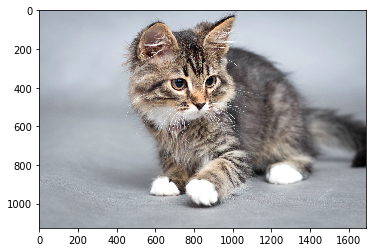

In [6]:
plt.imshow(image);

### Taille de l'array numpy

La taille en octets peut être calculée en multipliant le nombre d'éléments par la taille en octets de chaque élément du tableau.

La taille d'un élément dépend du type de données.

1 octet == 8 bits


In [7]:
image.shape

(1125, 1688, 3)

In [8]:
np.product(image.shape)

5697000

In [9]:
image.dtype

dtype('uint8')

In [10]:
1125 * 1688 * 3 * (8 / 8)

5697000.0

Si on demande à numpy

In [11]:
image.nbytes

5697000

In [12]:
print("image size: {:0.3} MB".format(image.nbytes / 1e6))

image size: 5.7 MB


L'indexation sur la dernière dimension permet d'extraire le contenu 2D d'un canal de couleur spécifique, par exemple le canal rouge:

In [13]:
red_channel = image[:, :, 0]
red_channel

array([[161, 163, 164, ..., 171, 173, 173],
       [163, 164, 164, ..., 170, 172, 172],
       [163, 164, 164, ..., 169, 171, 171],
       ...,
       [150, 151, 151, ..., 161, 160, 160],
       [150, 150, 150, ..., 161, 162, 163],
       [150, 150, 150, ..., 160, 162, 163]], dtype=uint8)

In [14]:
red_channel.min(), red_channel.max()

(0, 255)

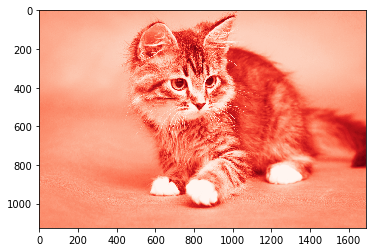

In [15]:
plt.imshow(image[:, :, 0], cmap=plt.cm.Reds_r);


## Redimensionner les images, gérer les types de données et les plages dynamiques

Lorsqu'il s'agit d'une collection hétérogène d'images de différentes tailles, il est souvent nécessaire de redimensionner l'image à la même taille. Plus précisement:

- pour la **classification d'image**, la plupart des réseaux s'attendent à une **taille d'entrée fixe spécifique**;

- pour la **détection d'objets** et la segmentation d'instances, les réseaux ont plus de flexibilité mais l'image doit avoir **approximativement la même taille que les images de l'ensemble d'apprentissage**.

De plus **les grandes images peuvent être beaucoup plus lentes à traiter** que les images plus petites (le nombre de pixels varie de façon quadratique avec la hauteur et la largeur).

In [16]:
from skimage.transform import resize

#image = imread('laptop.jpeg')
lowres_image = resize(image, (50, 50), mode='reflect', anti_aliasing=True)
lowres_image.shape

(50, 50, 3)

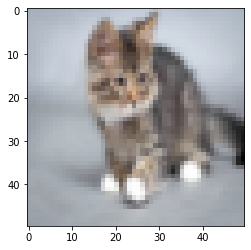

In [17]:
plt.imshow(lowres_image, interpolation='nearest');

Les valeurs des pixels de l'image basse résolution sont calculées à partir de la combinaison des valeurs des pixels dans l'image haute résolution. Le résultat est donc représenté en float.

In [18]:
lowres_image.dtype

dtype('float64')

In [19]:
print("image size: {:0.3} MB".format(lowres_image.nbytes / 1e6))

image size: 0.06 MB


Par convention, `skimage.transform.imresize` et `plt.imshow` supposent que les float vont de 0,0 à 1,0 lors de l'utilisation de virgules flottantes par opposition à 0 à 255 lors de l'utilisation d'entiers 8 bits:

In [20]:
lowres_image.min(), lowres_image.max()

(0.023529411764705882, 0.9921568627450981)

Notez que keras d'un autre côté peuvent s'attendre à des images encodées avec des valeurs dans la plage `[0.0 - 255.0]` indépendamment du type de données du tableau. Pour éviter la conversion implicite vers la plage `[0.0 - 1.0]`, nous utilisons l'option «preserve_range = True».

In [21]:
lowres_large_range_image = resize(image, (50, 50), mode='reflect',
                                  anti_aliasing=True, preserve_range=True)

In [22]:
lowres_large_range_image.shape

(50, 50, 3)

In [23]:
lowres_large_range_image.dtype

dtype('float64')

In [24]:
lowres_large_range_image.min(), lowres_large_range_image.max()

(6.0, 253.0)

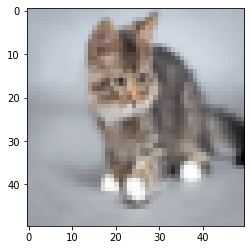

In [25]:
plt.imshow(lowres_large_range_image.astype(int), interpolation='nearest');

## Classification des images

Le package Keras comprend plusieurs modèles de réseau neuronal pré-entraînés sur l'ensemble de données de classification Image Net. Un modèle populaire qui montre un bon compromis entre la vitesse de calcul, la taille du modèle et la précision est appelé ResNet-50:

In [26]:
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50

model = ResNet50(weights='imagenet')

In [27]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

Vérifions que le backend tensorflow utilisé par Keras comme backend par défaut attend le canal de couleur sur le dernier axe. Si cela n'avait pas été le cas, il aurait été possible de changer l'ordre des axes avec `images = images.transpose (2, 0, 1)`.

In [28]:
import tensorflow.keras.backend as K

K.image_data_format()

'channels_last'

Le réseau a été entraîné sur des images RVB (224, 224)

In [29]:
model.input_shape

(None, 224, 224, 3)

`None` est utilisé par Keras pour marquer les dimensions avec un nombre dynamique d'éléments. Dans ce cas, `None` est la "taille du batch", c'est-à-dire le nombre d'images pouvant être traitées à la fois. Dans ce qui suit, nous ne traiterons qu'une seule image à la fois.

In [30]:
image = imread('https://www.wikichat.fr/wp-content/uploads/sites/2/comment-soigner-une-plaie-dun-chat.jpg')
image_224 = resize(image, (224, 224), preserve_range=True, mode='reflect')

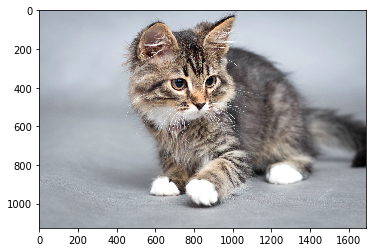

In [31]:
plt.imshow(image);

In [32]:
image_224.shape

(224, 224, 3)

In [33]:
image_224.dtype

dtype('float64')

In [34]:
image_224 = image_224.astype(np.float32)
image_224.dtype

dtype('float32')

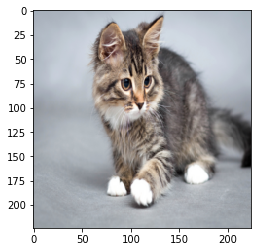

In [35]:
plt.imshow(image_224 / 255);


Notez que l'image a été déformée par le redimensionnement. 

En pratique, cela ne doit pas trop dégrader les performances du réseau.

Une alternative serait de:

- redimensionner l'image afin que le plus petit côté soit réglé sur 224;
- extraire un cadrage carré de taille (224, 224) de l'image résultante.

In [36]:
model.input_shape

(None, 224, 224, 3)

In [37]:
image_224.shape

(224, 224, 3)

In [38]:
image_224_batch = np.expand_dims(image_224, axis=0)
image_224_batch.shape

(1, 224, 224, 3)

`image_224_batch` est maintenant compatible avec la forme d'entrée du réseau neuronal, faisons une prédiction.

In [39]:
%%time
x = preprocess_input(image_224_batch.copy())
preds = model.predict(x)

CPU times: user 1.69 s, sys: 35.6 ms, total: 1.73 s
Wall time: 1.24 s


Les prédictions de sortie sont un tableau 2D:

- 1 ligne par image dans le lot,
- 1 colonne par classe cible dans le jeu de données ImageNet LSVRC (1000 classes possibles).

In [40]:
type(preds)

numpy.ndarray

In [41]:
preds.dtype

dtype('float32')

In [42]:
preds.shape

(1, 1000)

In [43]:
preds.sum(axis=1)

array([0.9999999], dtype=float32)

In [44]:
np.argmax(preds)

281

### Décodage des probabilités de prédiction

La lecture des probabilités brutes pour les 1000 classes Image Net possibles est fastidieuse. 

Heureusement, Keras est livré avec une fonction d'assistance pour extraire les classes les mieux notées en fonction du modèle et afficher à la fois les noms de classe et les identificateurs de synset wordnet:

In [45]:
from tensorflow.keras.applications.resnet50 import decode_predictions

decode_predictions(preds, top=5)

[[('n02123045', 'tabby', 0.3933876),
  ('n03942813', 'ping-pong_ball', 0.3626428),
  ('n02127052', 'lynx', 0.12961008),
  ('n02123159', 'tiger_cat', 0.076514594),
  ('n02113186', 'Cardigan', 0.0057569025)]]

In [46]:
print('Predicted image labels:')
class_names, confidences = [], []
for class_id, class_name, confidence in decode_predictions(preds, top=5)[0]:
    print("    {} (synset: {}): {:0.3f}".format(class_name, class_id, confidence))

Predicted image labels:
    tabby (synset: n02123045): 0.393
    ping-pong_ball (synset: n03942813): 0.363
    lynx (synset: n02127052): 0.130
    tiger_cat (synset: n02123159): 0.077
    Cardigan (synset: n02113186): 0.006


In [47]:
# pour une image aléatoire
image_224_batch = np.random.random(size = (1,224,224,3))
x = preprocess_input(image_224_batch.copy())
preds = model.predict(x)
decode_predictions(preds, top=5)

[[('n06359193', 'web_site', 0.06647057),
  ('n03196217', 'digital_clock', 0.0470377),
  ('n01930112', 'nematode', 0.04332039),
  ('n04404412', 'television', 0.04270779),
  ('n03729826', 'matchstick', 0.037794665)]]